In [1]:
import pandas as pd
import numpy as np
from math import radians, cos, sin, asin, sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMRegressor

In [2]:
merged_set = pd.read_csv("../Data_Cleanup/outCSV/Merged_set_new.csv", index_col=0, parse_dates=["start_time", "end_time"], low_memory=False)

merged_set = merged_set.dropna(subset=["idle_time"])

merged_set["idle_time"] = pd.to_timedelta(merged_set["idle_time"])
# Convert end_time to datetime and extract the hour
merged_set['end_time'] = pd.to_datetime(merged_set['end_time'])
merged_set['end_hour'] = merged_set['end_time'].dt.hour

# Convert idle_time to numeric (assuming it's in a format like '1h 30m')
merged_set['idle_time'] = merged_set['idle_time'].dt.total_seconds()/3600

## Create a mapping of day names to numbers
#day_mapping = {'monday': 1, 'tuesday': 2, 'wednesday': 3, 'thursday': 4, 'friday': 5, 'saturday': 6, 'sunday': 7}
#
## Apply idxmax along the columns and map the day names to numbers
#merged_set['day'] = merged_set[['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']].idxmax(axis=1).map(day_mapping)
#
## Drop the columns 'monday' to 'sunday'
#merged_set = merged_set.drop(['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday'], axis=1)
#
## Define a dictionary to map time-of-day names to numbers
#time_mapping = {'morgens': 1, 'vormittags': 2, 'mittags': 3, 'nachmittags': 4, 'abends': 5, 'nachts': 6}
#
## Create a new column 'time_of_day' by finding the column name where the maximum value is located for each row
#merged_set['time_of_day'] = merged_set[['morgens', 'vormittags', 'mittags', 'nachmittags', 'abends', 'nachts']].idxmax(axis=1)
#
## Map the time-of-day names to numbers
#merged_set['time_of_day'] = merged_set['time_of_day'].map(time_mapping)
#
## Drop the original columns
#merged_set = merged_set.drop(['morgens', 'vormittags', 'mittags', 'nachmittags', 'abends', 'nachts'], axis=1)


# Use LabelEncoder to convert cloud_cover_description to numeric
le = LabelEncoder()
merged_set['cloud_cover_description'] = le.fit_transform(merged_set['cloud_cover_description'])
merged_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1551807 entries, 0 to 1552774
Data columns (total 32 columns):
 #   Column                   Non-Null Count    Dtype         
---  ------                   --------------    -----         
 0   Unnamed: 0               1551807 non-null  int64         
 1   start_time               1551807 non-null  datetime64[ns]
 2   end_time                 1551807 non-null  datetime64[ns]
 3   start_station_id         1551807 non-null  int64         
 4   start_station_lat        1551807 non-null  float64       
 5   start_station_lon        1551807 non-null  float64       
 6   end_station_id           1551807 non-null  int64         
 7   end_station_lat          1551807 non-null  float64       
 8   end_station_lon          1551807 non-null  float64       
 9   bike_id                  1551807 non-null  object        
 10  idle_time                1551807 non-null  float64       
 11  morgens                  1551807 non-null  int64         
 12  

In [3]:
# Define target variable
y = merged_set['idle_time'].values

# Define features
X = merged_set.drop(['start_time', 'end_time', 'bike_id', 'idle_time','Unnamed: 0', 'start_station_id','start_station_lat','start_station_lon'], axis=1)
X.info(), X.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1551807 entries, 0 to 1552774
Data columns (total 24 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   end_station_id           1551807 non-null  int64  
 1   end_station_lat          1551807 non-null  float64
 2   end_station_lon          1551807 non-null  float64
 3   morgens                  1551807 non-null  int64  
 4   vormittags               1551807 non-null  int64  
 5   mittags                  1551807 non-null  int64  
 6   nachmittags              1551807 non-null  int64  
 7   abends                   1551807 non-null  int64  
 8   nachts                   1551807 non-null  int64  
 9   monday                   1551807 non-null  int64  
 10  tuesday                  1551807 non-null  int64  
 11  wednesday                1551807 non-null  int64  
 12  thursday                 1551807 non-null  int64  
 13  friday                   1551807 non-null 

(None,
    end_station_id  end_station_lat  end_station_lon  morgens  vormittags  \
 0            3029        34.048851      -118.246422        0           0   
 1            3028        34.058319      -118.246094        0           0   
 2            3018        34.043732      -118.260139        0           0   
 3            3031        34.044701      -118.252441        0           0   
 4            3031        34.044701      -118.252441        0           0   
 
    mittags  nachmittags  abends  nachts  monday  ...  saturday  sunday  \
 0        0            0       0       1       0  ...         0       1   
 1        0            0       0       1       0  ...         0       1   
 2        0            0       0       1       0  ...         0       1   
 3        0            0       0       1       0  ...         0       1   
 4        0            0       0       1       0  ...         0       1   
 
    temperature  cloud_cover  cloud_cover_description  pressure  windspeed  \

In [9]:
# Extract feature names
feature_names = X.columns.tolist()

# Perform train-validation-test split
X_train_val, X_test, y_train_val, y_test = train_test_split(X[feature_names], y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.285, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_train_val = scaler.transform(X_train_val)
X_test = scaler.transform(X_test)

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.base import clone

def train_and_evaluate(model, hyperparam_name, hyperparam_values, inner_loop):
    # Initialize a list to store the average MSE for each hyperparameter value
    avg_mse_values = []
    avg_mae_values = []
    avg_r2_values = []
    err_train = []
    err_cv = []

    # For each hyperparameter value, train the model and calculate the MSE
    for value in hyperparam_values:
        avg_mse = []
        avg_mae = []
        avg_r2 = []

        for i in range(inner_loop):
            # Create a copy of the model with the current hyperparameter value
            model_clone = clone(model)
            setattr(model_clone, hyperparam_name, value)

            # Train the model and make predictions
            model_clone.fit(X_train, y_train)
            preds = model_clone.predict(X_val)

            # Calculate the errors and store them in the lists
            avg_mae.append(mean_absolute_error(y_val, preds))
            avg_mse.append(mean_squared_error(y_val, preds))
            avg_r2.append(r2_score(y_val, preds))
            err_train.append(mean_squared_error(model_clone.predict(X_train), y_train))
            err_cv.append(mean_squared_error(model_clone.predict(X_val), y_val))



    # Compute the average errors for the current hyperparameter value
        avg_mse_values.append(np.mean(avg_mse))
        avg_mae_values.append(np.mean(avg_mae))
        avg_r2_values.append(np.mean(avg_r2))

        print(f'{hyperparam_name} {value}: Average MSE: {np.mean(avg_mse)}, Average MAE: {np.mean(avg_mae)}, Average R2: {np.mean(avg_r2)}')

    # Create a single figure with three subplots, one for each metric
    plt.figure(figsize = (8,6))
    plt.loglog(np.logspace(-15,10,100), err_train, np.logspace(-15,10,100), err_cv)
    plt.legend(["Training", "Validation"])
    plt.xlabel("$\lambda$ (or alpha in scikit learn terms)")
    plt.ylabel("Mean squared error")
    plt.show()

    plt.figure(figsize=(20, 5))

    # MSE
    plt.subplot(1, 3, 1)
    plt.plot(hyperparam_values, avg_mse_values, color='red')
    plt.xlabel(hyperparam_name)
    plt.ylabel('MSE')
    plt.title(f'MSE vs. {hyperparam_name}')

    # MAE
    plt.subplot(1, 3, 2)
    plt.plot(hyperparam_values, avg_mae_values, color='magenta')
    plt.xlabel(hyperparam_name)
    plt.ylabel('MAE')
    plt.title(f'MAE vs. {hyperparam_name}')

    # R2
    plt.subplot(1, 3, 3)
    plt.plot(hyperparam_values, avg_r2_values, color='cyan')
    plt.xlabel(hyperparam_name)
    plt.ylabel('R2')
    plt.title(f'R2 vs. {hyperparam_name}')

    # Adjust the layout and display the figure
    plt.tight_layout()
    plt.show()

max_depth 1: Average MSE: 25283.071031349067, Average MAE: 10.362004297608019, Average R2: 0.06930825422141262
max_depth 2: Average MSE: 21698.81811288151, Average MAE: 8.441333965650196, Average R2: 0.20124770896029265
max_depth 3: Average MSE: 7898.95155850439, Average MAE: 7.4826640488196166, Average R2: 0.7092327507726548
max_depth 4: Average MSE: 4804.905332206718, Average MAE: 5.728653536808256, Average R2: 0.823127272537916
max_depth 5: Average MSE: 3694.9857731137263, Average MAE: 4.632337530859024, Average R2: 0.863984372960773
max_depth 6: Average MSE: 3070.7165769812323, Average MAE: 4.188662315649221, Average R2: 0.8869642628350668
max_depth 7: Average MSE: 3030.3685023728362, Average MAE: 4.263249537534446, Average R2: 0.88844951041237
max_depth 8: Average MSE: 2737.5925891996935, Average MAE: 4.177165973941859, Average R2: 0.8992268453894054
max_depth 9: Average MSE: 2639.532503239791, Average MAE: 4.256974541395825, Average R2: 0.9028365220967982
max_depth 10: Average MS

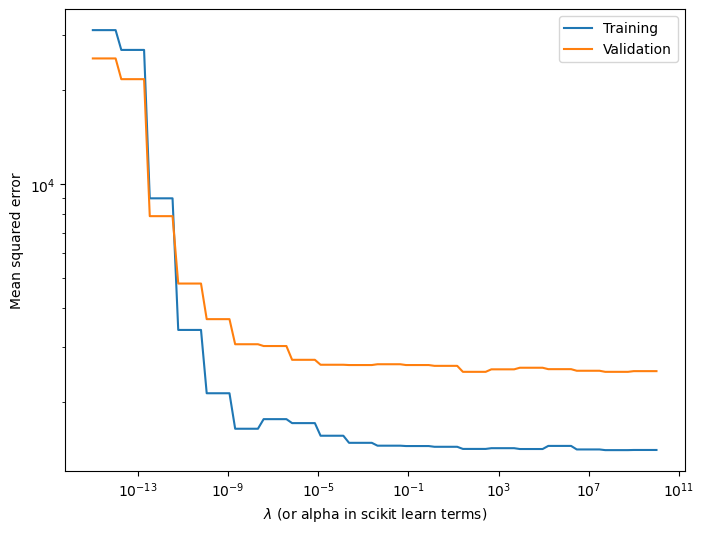

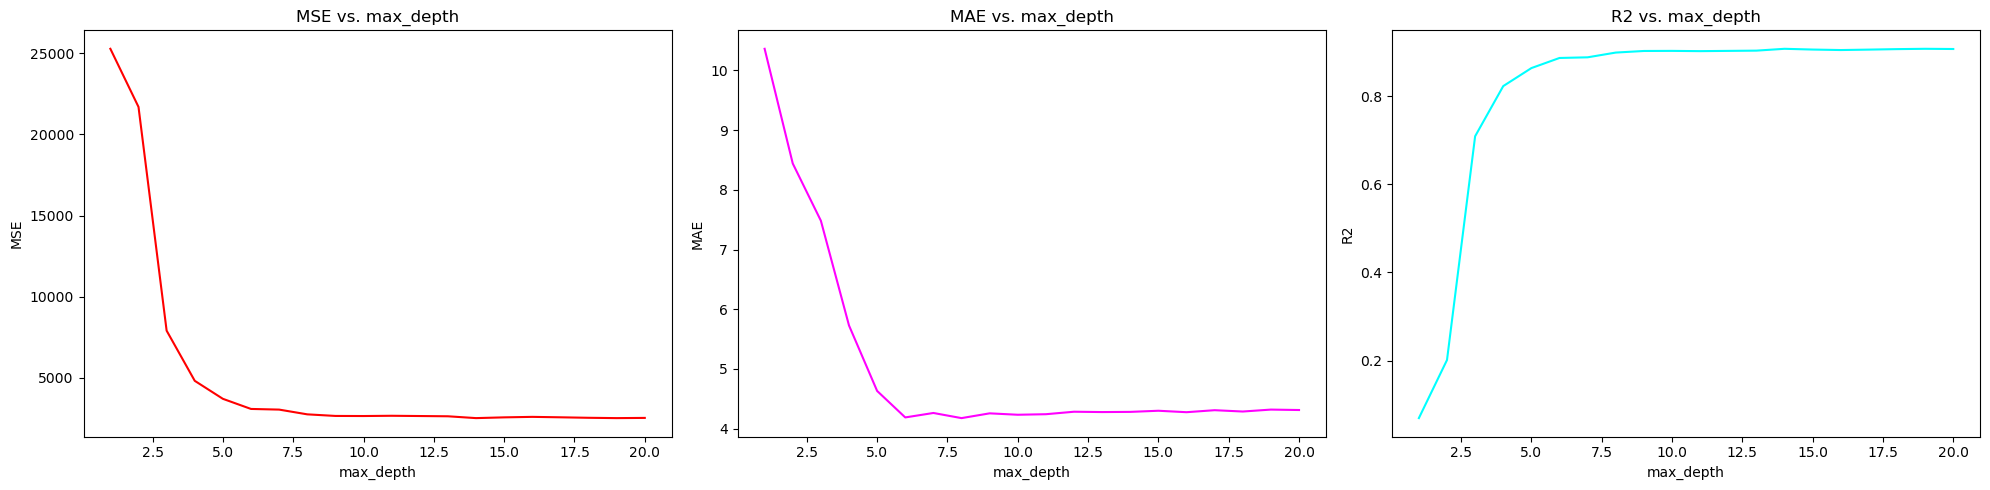

In [14]:
train_and_evaluate(LGBMRegressor(), "max_depth", range(1,21), 5)

max_depth 1: Average MSE: 26357.445477402653, Average MAE: 12.197980147946156, Average R2: 0.029759600200004278
max_depth 2: Average MSE: 25812.232905060067, Average MAE: 9.051337809886025, Average R2: 0.04982934727087192
max_depth 3: Average MSE: 25478.98537509502, Average MAE: 8.554926655403719, Average R2: 0.06209647752000236
max_depth 4: Average MSE: 25391.556028069062, Average MAE: 8.017085023698325, Average R2: 0.06531482751850434
max_depth 5: Average MSE: 11546.847912653044, Average MAE: 6.394580666248862, Average R2: 0.5749505260360976
max_depth 6: Average MSE: 9504.268554539221, Average MAE: 5.574353098190168, Average R2: 0.6501396415647116
max_depth 7: Average MSE: 7278.20558385215, Average MAE: 4.878674585315857, Average R2: 0.7320829478123179
max_depth 8: Average MSE: 7062.060338018762, Average MAE: 4.320660668453874, Average R2: 0.7400394415443092
max_depth 9: Average MSE: 5998.864377466208, Average MAE: 4.052309156836833, Average R2: 0.7791766058312143
max_depth 10: Avera

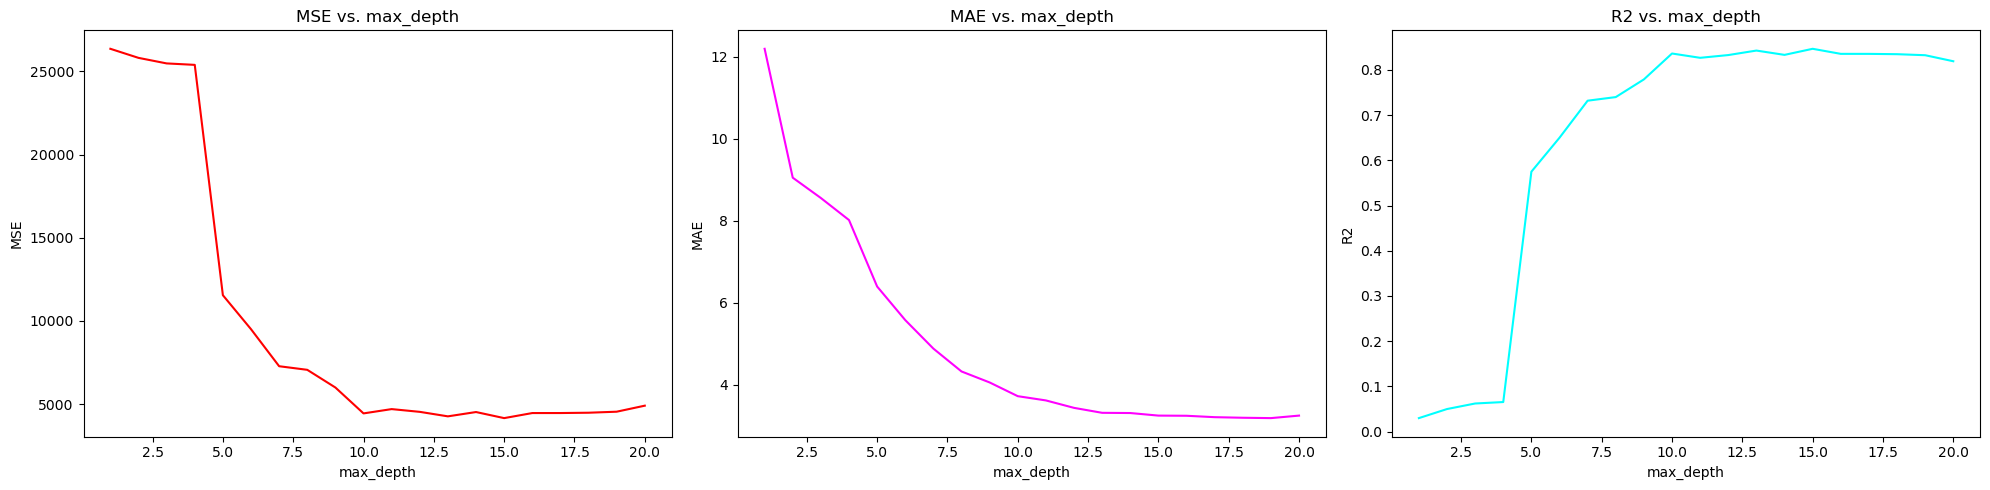

In [72]:
train_and_evaluate(DecisionTreeRegressor(), "max_depth", range(1,21), 5)

In [6]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb

# Define the parameter grid
param_grid = {
    'max_depth': [10, 20, 30],
    'learning_rate': [0.01, 0.1, 1],
    'num_leaves': [31, 62, 93],
    'n_estimators': [100, 200, 300]
}

# Create a LightGBM model
model = lgb.LGBMRegressor()

# Create the grid search object
grid = GridSearchCV(model, param_grid, cv=5, scoring='r2')

# Fit the grid search object to the data
grid.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print(grid.best_params_)
print(grid.best_score_)

lgbm_best = grid.best_estimator_
lgbm_test_preds = lgbm_best.predict(X_test)

# Calculate and print the metrics for the test set
lgbm_test_mse = mean_squared_error(y_test, lgbm_test_preds)
lgbm_test_mae = mean_absolute_error(y_test, lgbm_test_preds)
lgbm_test_r2 = r2_score(y_test, lgbm_test_preds)

print('LightGBM Test MSE:', lgbm_test_mse)
print('LightGBM Test MAE:', lgbm_test_mae)
print('LightGBM Test R2:', lgbm_test_r2)

{'learning_rate': 0.1, 'max_depth': 30, 'n_estimators': 300, 'num_leaves': 93}
0.9288346472216817
LightGBM Test MSE: 414029.29536781454
LightGBM Test MAE: 91.40366687505639
LightGBM Test R2: -14.976232763588301


In [86]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

# Define the parameter grid
param_grid = {
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# Create a DecisionTreeRegressor model
model = DecisionTreeRegressor()

# Create the grid search object
grid = GridSearchCV(model, param_grid, cv=5, scoring='r2')

# Fit the grid search object to the data
grid.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print(grid.best_params_)
print(grid.best_score_)

# Use the best estimator from the grid search to make predictions on the test set
dt_best = grid.best_estimator_
dt_test_preds = dt_best.predict(X_test)

# Calculate and print the metrics for the test set
dt_test_mse = mean_squared_error(y_test, dt_test_preds)
dt_test_mae = mean_absolute_error(y_test, dt_test_preds)
dt_test_r2 = r2_score(y_test, dt_test_preds)

print('Decision Tree Test MSE:', dt_test_mse)
print('Decision Tree Test MAE:', dt_test_mae)
print('Decision Tree Test R2:', dt_test_r2)

C:\Users\yusuf\anaconda3\envs\DSML_Team01\lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\yusuf\anaconda3\envs\DSML_Team01\lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\yusuf\anaconda3\envs\DSML_Team01\lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
C:\Users\yusuf\anaconda3\envs\DSML_Team01\lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, e

{'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5}
0.9165272650000498
Decision Tree Test MSE: 25071.386731561226
Decision Tree Test MAE: 7.039443430047556
Decision Tree Test R2: 0.03256529281696141


C:\Users\yusuf\anaconda3\envs\DSML_Team01\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


In [87]:
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

# Define the base models
base_models = [
    ('decision_tree', DecisionTreeRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=1, min_samples_split=2)),
    ('lgbm', LGBMRegressor(learning_rate=0.1, max_depth=30, n_estimators=300, num_leaves=93))
]

# Define the meta model
meta_model = LinearRegression()

# Define the stacking ensemble
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model)

# Train the stacking ensemble
stacking_model.fit(X_train, y_train)

# Make predictions
preds = stacking_model.predict(X_val)

# Evaluate the model
score = r2_score(y_val, preds)
print(score)

0.898090899323079


Loop 0: MSE: 1949.0340735474606, MAE: 3.5665122876958923, R2: 0.9282543674285976
Loop 1: MSE: 2095.9067396266814, MAE: 3.621365677554815, R2: 0.9228478573637824
Loop 2: MSE: 1883.7845164224084, MAE: 3.5930746385505747, R2: 0.9306562601479076
Loop 3: MSE: 2047.037427431711, MAE: 3.6638885419725047, R2: 0.9246467790780529
Loop 4: MSE: 2372.28866393034, MAE: 3.580644027902015, R2: 0.9126739993181013
Loop 5: MSE: 2079.017039461796, MAE: 3.6948488820219487, R2: 0.9234695818573238
Loop 6: MSE: 2432.911971515142, MAE: 3.5910364219256623, R2: 0.9104424028517935
Loop 7: MSE: 2099.4902649563646, MAE: 3.7270854208010182, R2: 0.922715944692217
Loop 8: MSE: 2141.6505718507296, MAE: 3.6362452098841054, R2: 0.921163987274646
Loop 9: MSE: 1827.465635963978, MAE: 3.5629699781851913, R2: 0.9327294069230426
Loop 10: MSE: 1962.4984131430015, MAE: 3.519824753389838, R2: 0.9277587334247857
Loop 11: MSE: 2264.863544409199, MAE: 3.356520314429711, R2: 0.9166284110232157
Loop 12: MSE: 1995.6655349151524, MAE: 

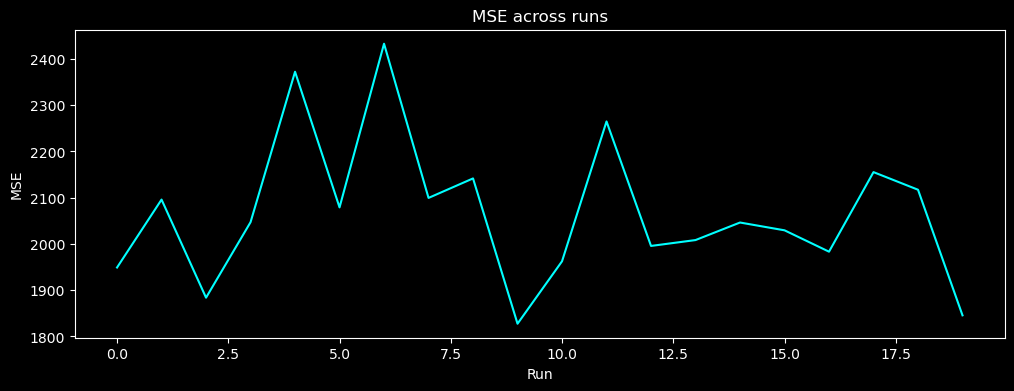

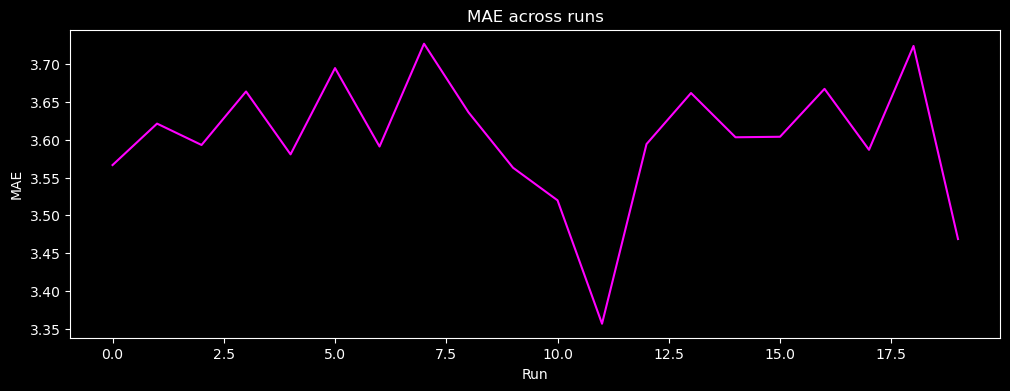

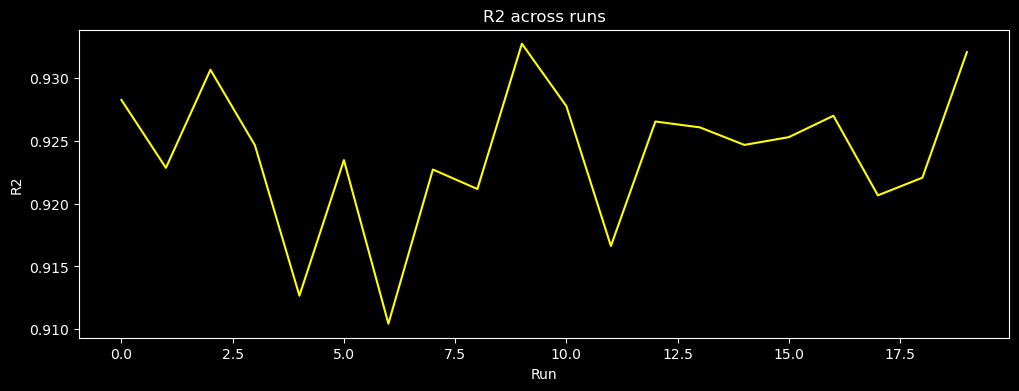

In [88]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

# Define the base models
base_models = [
    ('decision_tree', DecisionTreeRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=1, min_samples_split=2)),
    ('lgbm', LGBMRegressor(learning_rate=0.1, max_depth=30, n_estimators=300, num_leaves=93))
]

# Define the meta model
meta_model = LinearRegression()

# Define the stacking ensemble
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model)

# Arrays to store the metrics
mse_values = []
mae_values = []
r2_values = []

# Run the model 20 times
for _ in range(20):
    # Train the stacking ensemble
    stacking_model.fit(X_train, y_train)

    # Make predictions
    preds = stacking_model.predict(X_val)

    # Calculate and store the metrics
    mse_values.append(mean_squared_error(y_val, preds))
    mae_values.append(mean_absolute_error(y_val, preds))
    r2_values.append(r2_score(y_val, preds))
    print(f'Loop {_}: MSE: {mean_squared_error(y_val, preds)}, MAE: {mean_absolute_error(y_val, preds)}, R2: {r2_score(y_val, preds)}')

# Print the mean of the metrics
print('Mean MSE:', np.mean(mse_values))
print('Mean MAE:', np.mean(mae_values))
print('Mean R2:', np.mean(r2_values))


# MSE
plt.figure(figsize=(12, 4))
plt.plot(mse_values, color='cyan')
plt.xlabel('Run')
plt.ylabel('MSE')
plt.title('MSE across runs')
plt.show()

# MAE
plt.figure(figsize=(12, 4))
plt.plot(mae_values, color='magenta')
plt.xlabel('Run')
plt.ylabel('MAE')
plt.title('MAE across runs')
plt.show()

# R2
plt.figure(figsize=(12, 4))
plt.plot(r2_values, color='yellow')
plt.xlabel('Run')
plt.ylabel('R2')
plt.title('R2 across runs')
plt.show()


Loop 0: Val MSE: 2066.6497051392344, Val MAE: 3.6536866389975597, Val R2: 0.9239248341467715
Loop 0: Test MSE: 1856.6524782042275, Test MAE: 3.6979423384103227, Test R2: 0.9283569725989258
Loop 1: Val MSE: 1917.07918490231, Val MAE: 3.605811806902472, Val R2: 0.929430654560111
Loop 1: Test MSE: 1766.517410976929, Test MAE: 3.646450777203828, Test R2: 0.931835032799728
Loop 2: Val MSE: 2062.0281089462565, Val MAE: 3.4870571056438093, Val R2: 0.9240949591060296
Loop 2: Test MSE: 1953.5204658155008, Test MAE: 3.5215067597201344, Test R2: 0.9246191078276823
Loop 3: Val MSE: 2057.6989390351023, Val MAE: 3.6404925865756192, Val R2: 0.9242543196005434
Loop 3: Test MSE: 1808.1666521294267, Test MAE: 3.674161715847498, Test R2: 0.9302279050468767
Loop 4: Val MSE: 2222.304539476029, Val MAE: 3.592015227659668, Val R2: 0.9181950448609619
Loop 4: Test MSE: 2442.2056159363424, Test MAE: 3.6946399584767455, Test R2: 0.9057621143883563
Loop 5: Val MSE: 2039.6034997421764, Val MAE: 3.5947680153193367,

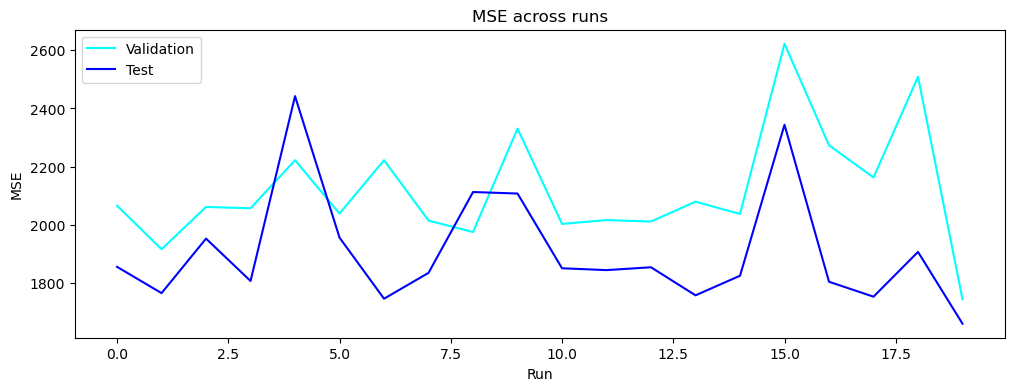

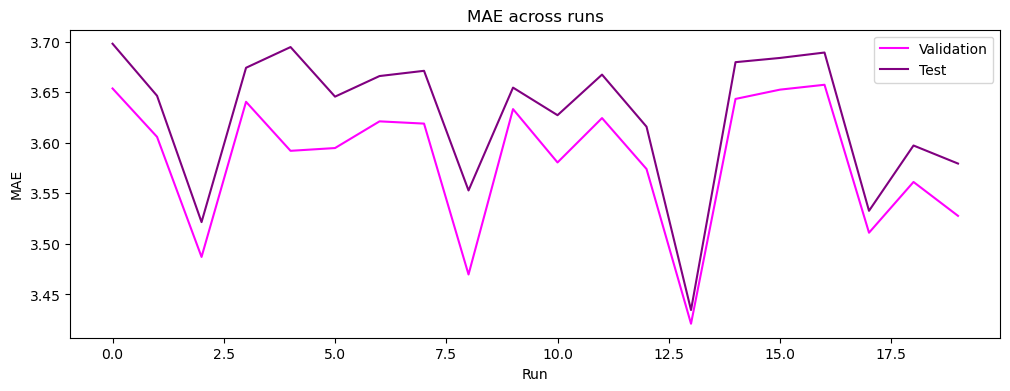

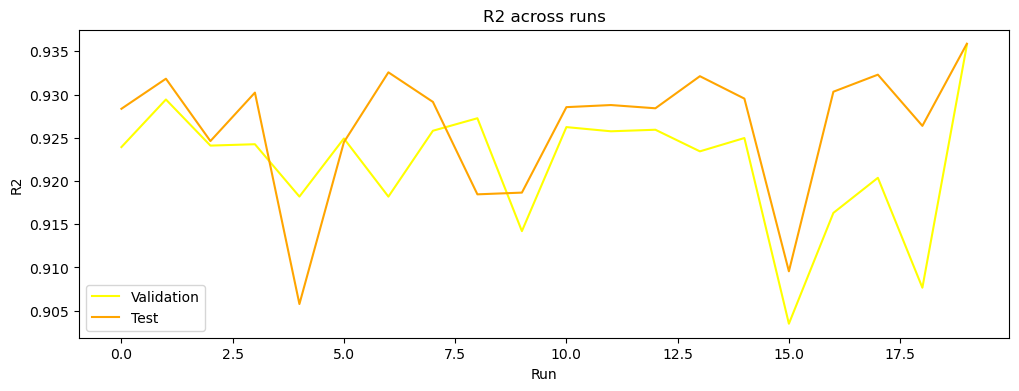

In [19]:
# Arrays to store the metrics for validation and test sets
mse_values = []
mae_values = []
r2_values = []
test_mse_values = []
test_mae_values = []
test_r2_values = []

# Run the model 20 times
for _ in range(20):
    # Train the stacking ensemble
    stacking_model.fit(X_train, y_train)

    # Make predictions on the validation set
    preds_val = stacking_model.predict(X_val)

    # Calculate and store the metrics for validation set
    mse_values.append(mean_squared_error(y_val, preds_val))
    mae_values.append(mean_absolute_error(y_val, preds_val))
    r2_values.append(r2_score(y_val, preds_val))
    print(f'Loop {_}: Val MSE: {mean_squared_error(y_val, preds_val)}, Val MAE: {mean_absolute_error(y_val, preds_val)}, Val R2: {r2_score(y_val, preds_val)}')

    # Make predictions on the test set
    preds_test = stacking_model.predict(X_test)

    # Calculate and store the metrics for test set
    test_mse_values.append(mean_squared_error(y_test, preds_test))
    test_mae_values.append(mean_absolute_error(y_test, preds_test))
    test_r2_values.append(r2_score(y_test, preds_test))
    print(f'Loop {_}: Test MSE: {mean_squared_error(y_test, preds_test)}, Test MAE: {mean_absolute_error(y_test, preds_test)}, Test R2: {r2_score(y_test, preds_test)}')

# Print the mean of the metrics for validation set
print('Mean Val MSE:', np.mean(mse_values))
print('Mean Val MAE:', np.mean(mae_values))
print('Mean Val R2:', np.mean(r2_values))

# Print the mean of the metrics for test set
print('Mean Test MSE:', np.mean(test_mse_values))
print('Mean Test MAE:', np.mean(test_mae_values))
print('Mean Test R2:', np.mean(test_r2_values))

# MSE
plt.figure(figsize=(12, 4))
plt.plot(mse_values, color='cyan', label='Validation')
plt.plot(test_mse_values, color='blue', label='Test')
plt.xlabel('Run')
plt.ylabel('MSE')
plt.title('MSE across runs')
plt.legend()
plt.show()

# MAE
plt.figure(figsize=(12, 4))
plt.plot(mae_values, color='magenta', label='Validation')
plt.plot(test_mae_values, color='purple', label='Test')
plt.xlabel('Run')
plt.ylabel('MAE')
plt.title('MAE across runs')
plt.legend()
plt.show()

# R2
plt.figure(figsize=(12, 4))
plt.plot(r2_values, color='yellow', label='Validation')
plt.plot(test_r2_values, color='orange', label='Test')
plt.xlabel('Run')
plt.ylabel('R2')
plt.title('R2 across runs')
plt.legend()
plt.show()


In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
# Define the base models
base_models = [
    ('decision_tree', DecisionTreeRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=1, min_samples_split=2)),
    ('lgbm', LGBMRegressor(learning_rate=0.1, max_depth=30, n_estimators=300, num_leaves=93))
]

# Define the meta model
meta_model = LinearRegression()

# Define the stacking ensemble
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model)
# Train the stacking ensemble on the training set
stacking_model.fit(X_train, y_train)

# Evaluate on the validation set
val_preds = stacking_model.predict(X_val)
print('Validation MSE:', mean_squared_error(y_val, val_preds))
print('Validation MAE:', mean_absolute_error(y_val, val_preds))
print('Validation R2:', r2_score(y_val, val_preds))

# After you're done with all the fine-tuning and are satisfied with the model performance on the validation set,
# you can evaluate the model on the test set.
test_preds = stacking_model.predict(X_test)
print('Test MSE:', mean_squared_error(y_test, test_preds))
print('Test MAE:', mean_absolute_error(y_test, test_preds))
print('Test R2:', r2_score(y_test, test_preds))

Validation MSE: 2305.5443939162756
Validation MAE: 3.4840856673295866
Validation R2: 0.9151309137136305
Test MSE: 1635.2691609420692
Test MAE: 3.5324998355615684
Test R2: 0.9368995357608235


Validation MSE: 2704.710310248049
Validation MAE: 3.4671501941728615
Validation R2: 0.90043727056144
Test MSE: 1875.2996382711851
Test MAE: 3.4928559276591447
Test R2: 0.9276374308347495


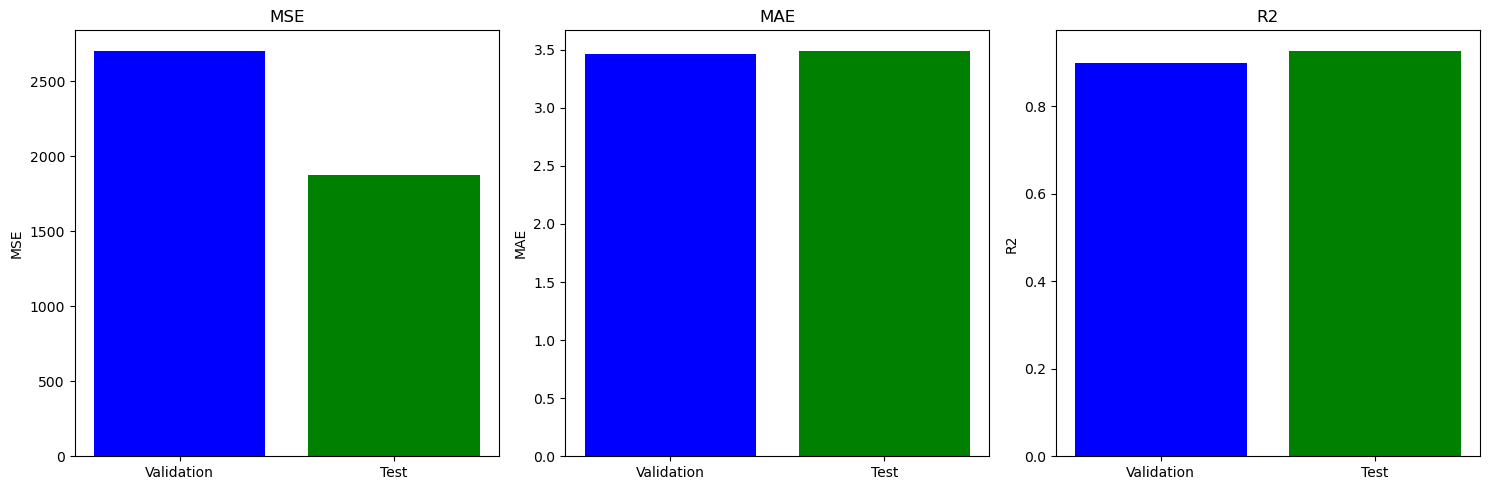

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Train the stacking ensemble on the training set
stacking_model.fit(X_train, y_train)

# Evaluate on the validation set
val_preds = stacking_model.predict(X_val)
val_mse = mean_squared_error(y_val, val_preds)
val_mae = mean_absolute_error(y_val, val_preds)
val_r2 = r2_score(y_val, val_preds)

print('Validation MSE:', val_mse)
print('Validation MAE:', val_mae)
print('Validation R2:', val_r2)

# After you're done with all the fine-tuning and are satisfied with the model performance on the validation set,
# you can evaluate the model on the test set.
test_preds = stacking_model.predict(X_test)
test_mse = mean_squared_error(y_test, test_preds)
test_mae = mean_absolute_error(y_test, test_preds)
test_r2 = r2_score(y_test, test_preds)

print('Test MSE:', test_mse)
print('Test MAE:', test_mae)
print('Test R2:', test_r2)

# Define the labels and values for the bar plots
labels = ['MSE', 'MAE', 'R2']
val_values = [val_mse, val_mae, val_r2]
test_values = [test_mse, test_mae, test_r2]

# Create a figure with three subplots
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# For each metric, create a bar plot comparing the validation and test values
for i in range(3):
    ax[i].bar(['Validation', 'Test'], [val_values[i], test_values[i]], color=['blue', 'green'])
    ax[i].set_title(labels[i])
    ax[i].set_ylabel(labels[i])

# Adjust the layout and display the figure
plt.tight_layout()
plt.show()


Validation MSE: 4031.121137878869
Validation MAE: 3.571566750217511
Validation R2: 0.8516109390111039
Test MSE: 2590336.7200049656
Test MAE: 171.14696839489162
Test R2: -98.95385070060009


C:\Users\yusuf\anaconda3\envs\DSML_Team01\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


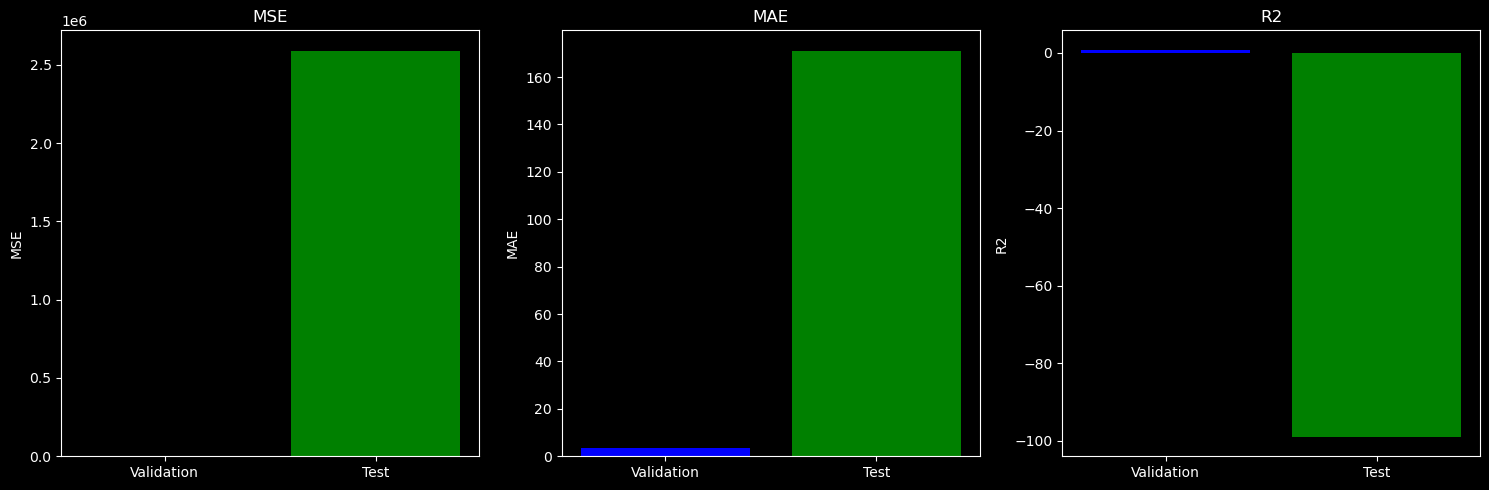

In [91]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Train the stacking ensemble on the training set
tree_model = DecisionTreeRegressor(max_depth=11)
tree_model.fit(X_train, y_train)
# Evaluate on the validation set
val_preds = tree_model.predict(X_val)
val_mse = mean_squared_error(y_val, val_preds)
val_mae = mean_absolute_error(y_val, val_preds)
val_r2 = r2_score(y_val, val_preds)

print('Validation MSE:', val_mse)
print('Validation MAE:', val_mae)
print('Validation R2:', val_r2)

# After you're done with all the fine-tuning and are satisfied with the model performance on the validation set,
# you can evaluate the model on the test set.
test_preds = tree_model.predict(X_test)
test_mse = mean_squared_error(y_test, test_preds)
test_mae = mean_absolute_error(y_test, test_preds)
test_r2 = r2_score(y_test, test_preds)

print('Test MSE:', test_mse)
print('Test MAE:', test_mae)
print('Test R2:', test_r2)

# Define the labels and values for the bar plots
labels = ['MSE', 'MAE', 'R2']
val_values = [val_mse, val_mae, val_r2]
test_values = [test_mse, test_mae, test_r2]

# Create a figure with three subplots
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# For each metric, create a bar plot comparing the validation and test values
for i in range(3):
    ax[i].bar(['Validation', 'Test'], [val_values[i], test_values[i]], color=['blue', 'green'])
    ax[i].set_title(labels[i])
    ax[i].set_ylabel(labels[i])

# Adjust the layout and display the figure
plt.tight_layout()
plt.show()


In [10]:
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.metrics import r2_score

# Define the base models
base_models = [
    ('decision_tree', DecisionTreeRegressor(max_depth=20, max_features='sqrt', min_samples_leaf=1, min_samples_split=2)),
    ('lgbm', LGBMRegressor(learning_rate=0.1, max_depth=30, n_estimators=300, num_leaves=93))
]

# Define the meta models
meta_models = [
    LinearRegression(),
    Ridge(),
    Lasso(),
    RandomForestRegressor(n_estimators=100, max_depth=10, random_state=0),
]

# For each meta model, create a stacking ensemble, train it and evaluate it
for meta_model in meta_models:
    print(f"Training StackingRegressor with {type(meta_model).__name__} as meta-model...")
    stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model)
    stacking_model.fit(X_train, y_train)
    preds = stacking_model.predict(X_val)
    score = r2_score(y_val, preds)
    print(f"{type(meta_model).__name__} - R2 score: {score}\n")


Training StackingRegressor with LinearRegression as meta-model...
LinearRegression - R2 score: 0.9106365269653863



C:\Users\yusuf\anaconda3\envs\DSML_Team01\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


Test MSE: 243125.1486999424
Test MAE: 69.78608561489513
Test R2: -8.38151964068542
----------------------------------------------------------------------------
Training StackingRegressor with Ridge as meta-model...
Ridge - R2 score: 0.921403193333601



C:\Users\yusuf\anaconda3\envs\DSML_Team01\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


Test MSE: 358822.5435306996
Test MAE: 85.01202254830645
Test R2: -12.845958584105766
----------------------------------------------------------------------------
Training StackingRegressor with Lasso as meta-model...
Lasso - R2 score: 0.9367838424287038



C:\Users\yusuf\anaconda3\envs\DSML_Team01\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


Test MSE: 167549.64604327135
Test MAE: 57.59755555730751
Test R2: -5.465272323945371
----------------------------------------------------------------------------
Training StackingRegressor with RandomForestRegressor as meta-model...
RandomForestRegressor - R2 score: 0.925992413343301



C:\Users\yusuf\anaconda3\envs\DSML_Team01\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


Test MSE: 23102.84475013021
Test MAE: 9.059993929746826
Test R2: 0.10852582327241589
----------------------------------------------------------------------------


In [6]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

classifier = Sequential()

classifier.add(Dense(input_shape= (24,),
                     units=10,
                     activation='relu'))

classifier.add(Dropout(rate=0.1))

# adding the second hidden layer
classifier.add(Dense(units= 10,
                     activation='relu'))

# adding dropout to prevent overfitting
classifier.add(Dropout(rate=0.1))
# adding the output layer
classifier.add(Dense(units = 1,
                     activation='relu'))

# compiling the ANN
classifier.compile(optimizer="adam",
                   loss="binary_crossentropy",
                   metrics=["accuracy"])
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                250       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 371
Trainable params: 371
Non-trainable params: 0
_________________________________________________________________


In [7]:
# fitting the ANN to the training set
classifier.fit(X_train, y_train, batch_size=50, epochs=50)

Epoch 1/50
15534/15534 [==============================] - 21s 1ms/step - loss: -144.4078 - accuracy: 0.0465
Epoch 2/50
15534/15534 [==============================] - 20s 1ms/step - loss: -145.9402 - accuracy: 0.0547
Epoch 3/50
15534/15534 [==============================] - 20s 1ms/step - loss: -146.1058 - accuracy: 0.0551
Epoch 4/50
15534/15534 [==============================] - 21s 1ms/step - loss: -146.1280 - accuracy: 0.0553
Epoch 5/50
15534/15534 [==============================] - 19s 1ms/step - loss: -146.1385 - accuracy: 0.0553
Epoch 6/50
15534/15534 [==============================] - 18s 1ms/step - loss: -146.1519 - accuracy: 0.0553
Epoch 7/50
15534/15534 [==============================] - 19s 1ms/step - loss: -146.1604 - accuracy: 0.0554
Epoch 8/50
15534/15534 [==============================] - 17s 1ms/step - loss: -146.1445 - accuracy: 0.0552
Epoch 9/50
15534/15534 [==============================] - 20s 1ms/step - loss: -146.1629 - accuracy: 0.0551
Epoch 10/50
15534/15534 [===